In [3]:
# %% [markdown]
# # Multi-Class Logistic Regression Testing
# This notebook is used only for testing a pre-trained multi-class logistic regression model.
# It loads the model and scaler, then evaluates the model on a chosen fraction of a new dataset.

# %% [code]
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_curve, auc)

In [4]:
# %% [markdown]
# ## Parameter Definition
# Adjust the paths and sample fraction as needed.

# Path to the dataset (CSV file)
test_dataset_path = "/Users/book_kuno/Desktop/capture_final.csv"  # UPDATE AS NEEDED

# Fraction of the dataset to use for testing (e.g., 1 for 100%, 0.1 for 10%)
sample_fraction_test = 1

# Run name for saving outputs
run_name_test = "svm_test1_run_full"  # Change as desired
year_test = "2018"



In [5]:
# Define the output folder for this run
output_folder = os.path.join("outputs", year_test, "svm", run_name_test)
os.makedirs(output_folder, exist_ok=True)
print("Output folder created:", output_folder)


Output folder created: outputs/2018/svm/svm_test1_run_full


In [6]:
import joblib

# Update these paths to your saved model and scaler
model_path = "/Users/book_kuno/Desktop/Outputs 23:04 rfc and 1dd cnn/2018/svm/svm_final.pkl"
scaler_path = "/Users/book_kuno/Desktop/Outputs 23:04 rfc and 1dd cnn/2018/svm/scaler_final.pkl"

# Save the trained model and scaler correctly
joblib.dump(trained_model, "svm_final.pkl")
joblib.dump(scaler, "scaler_final.pkl")

# Load the model and scaler
model = joblib.load(model_path)
scaler_loaded = joblib.load(scaler_path)

# Check if the loaded model is a string (which means it was saved incorrectly)
if isinstance(model, str):
    raise ValueError(
        "The loaded model is a string. This likely indicates that the model was not saved properly. "
        "Please ensure you saved your trained model using joblib.dump(your_model, model_path) "
        "and not just the model path or any string."
    )

print("Loaded model type:", type(model))
print("Loaded scaler type:", type(scaler_loaded))


NameError: name 'trained_model' is not defined

In [ ]:
# %% [markdown]
# ## Data Loading & Preprocessing

# Load the dataset
data = pd.read_csv(test_dataset_path)
print("Original dataset shape:", data.shape)
print("First few rows:")
print(data.head())
print("\nDataset info:")
print(data.info())
print("\nClass distribution:")
print(data['label'].value_counts())

# Sample a fraction of the dataset for testing
data = data.sample(frac=sample_fraction_test, random_state=42).reset_index(drop=True)
print(f"Dataset shape after sampling {sample_fraction_test*100:.0f}%:", data.shape)

# Remove any unwanted rows (e.g., if header rows were misread as data)
data = data[data['label'] != 'label']

# Verify unique labels
print("Unique labels before encoding:")
print(data['label'].unique())


/var/folders/r9/g1ll_nxx2n70f0475ch9wkyr0000gn/T/ipykernel_30901/2594426010.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Original dataset shape: (4339651, 26)
First few rows:
    timestamp  Dst Port protocol  Flow Duration  Flow Duration_rolling_mean  \
0  1518745716   55250.0      6.0       958807.0                   1815614.1   
1  1519099848     443.0      6.0      6081730.0                   2284039.7   
2  1519179901   52453.0      6.0         1428.0                      6703.5   
3  1518659728    3389.0      6.0      2169521.0                   9191415.4   
4  1519116456   49913.0      6.0           97.0                  24709922.5   

   Flow Duration_rolling_std  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
0               1.965582e+06           5.0           3.0            935.0   
1               2.888929e+06          10.0          12.0            646.0   
2               8.135168e+03           5.0           2.0            935.0   
3               2.752269e+07           8.0           7.0           1132.0   
4               4.818137e+07           3.0           1.0             31.0   

   TotLe

In [ ]:
# %% [code]
# #### Encode Labels Dynamically
# Factorize the 'label' column so that each unique label is assigned a unique integer.
data['label'], uniques = pd.factorize(data['label'])
label_names = {i: label for i, label in enumerate(uniques)}
print("\nEncoded labels mapping:")
print(label_names)

# %% [code]
# #### Feature Selection
# Choose all columns except 'timestamp' and 'label'. You can override this by manually defining features.
selected_features = [col for col in data.columns if col.lower() not in ['timestamp', 'label']]
print("\nSelected features:")
print(selected_features)

X = data[selected_features]
y = data['label']

# Drop rows with missing values in features
num_rows_before = X.shape[0]
X = X.dropna()
num_rows_after = X.shape[0]
print("Number of rows dropped due to missing values:", num_rows_before - num_rows_after)


Encoded labels mapping:
{0: 'Benign', 1: 'DoS attacks-Hulk', 2: 'DDoS attacks-LOIC-HTTP', 3: 'DDOS attack-HOIC', 4: 'DoS attacks-SlowHTTPTest', 5: 'DoS attacks-GoldenEye', 6: 'DoS attacks-Slowloris', 7: 'DDOS attack-LOIC-UDP'}

Selected features:
['Dst Port', 'protocol', 'Flow Duration', 'Flow Duration_rolling_mean', 'Flow Duration_rolling_std', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'SYN Flag Cnt', 'pkts_ratio', 'byte_per_duration', 'entropy_pkt_len', 'Subflow Fwd Byts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min']
Number of rows dropped due to missing values: 0


In [ ]:
import joblib
import numpy as np

# #### Standardize Features using the Loaded Scaler

# Assume X is your test DataFrame (with only numeric columns, after any dropping)
# Get the expected feature names from the scaler
expected_features = list(scaler_loaded.feature_names_in_)
print("Expected features from training:", expected_features)

# Ensure that X contains all expected features:
# For any missing feature, add it with a default value (e.g., 0)
for feat in expected_features:
    if feat not in X.columns:
        print(f"Adding missing feature: {feat}")
        X[feat] = 0  # Set a default value; adjust if necessary

# Reorder X so that its columns match the training order exactly
X_aligned = X[expected_features]

# Now transform the test features using the loaded scaler
X_scaled = scaler_loaded.transform(X_aligned)
print("Scaled features shape:", X_scaled.shape)


Expected features from training: ['timestamp', 'Dst Port', 'Flow Duration', 'Flow Duration_rolling_mean', 'Flow Duration_rolling_std', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'SYN Flag Cnt', 'pkts_ratio', 'byte_per_duration', 'entropy_pkt_len', 'Subflow Fwd Byts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min']
Adding missing feature: timestamp
Scaled features shape: (216983, 24)


/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(



Test Accuracy: 0.0323


/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/book_kuno/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
                          precision    recall  f1-score   support

                  Benign       0.00      0.00      0.00    120554
        DoS attacks-Hulk       0.00      0.00      0.00     23165
  DDoS attacks-LOIC-HTTP       0.00      0.00      0.00     28729
        DDOS attack-HOIC       0.00      0.00      0.00     34270
DoS attacks-SlowHTTPTest       0.03      1.00      0.06      7018
   DoS attacks-GoldenEye       0.00      0.00      0.00      2485
   DoS attacks-Slowloris       0.00      0.00      0.00       678
    DDOS attack-LOIC-UDP       0.00      0.00      0.00        84

                accuracy                           0.03    216983
               macro avg       0.00      0.12      0.01    216983
            weighted avg       0.00      0.03      0.00    216983


Confusion Matrix:
[[     0      0      0      0 120554      0      0      0]
 [     0      0      0      0  23165      0      0      0]
 [     0      0      0      0  28729      0 

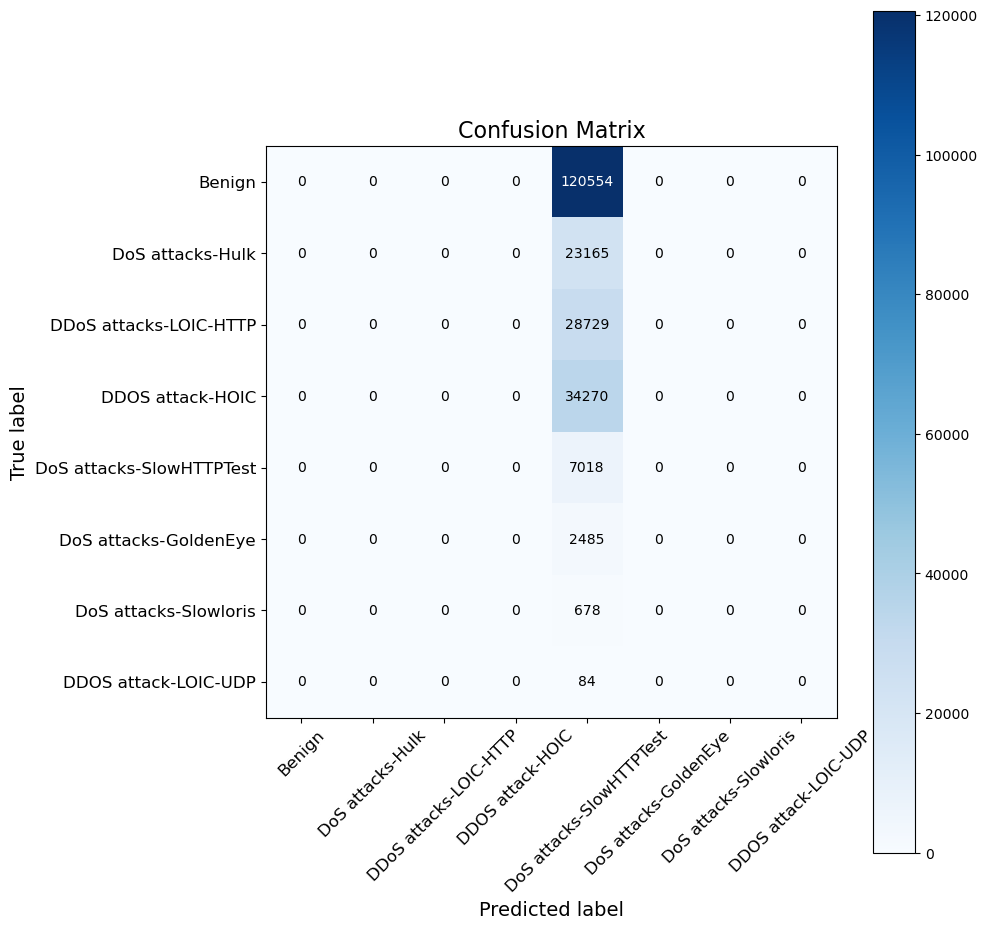

In [ ]:
# %% [code]
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# ---------------------------
# Model Evaluation
# ---------------------------
# Here we use the entire processed dataset as our test set.
y_test = y
y_test_pred = model.predict(X_scaled)

# Compute evaluation metrics
acc = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {acc:.4f}")

report = classification_report(y_test, y_test_pred, target_names=[str(label) for label in label_names.values()])
print("\nClassification Report:")
print(report)

cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)

# (Optional) Compute ROC Curve and AUC for one positive class (example using pos_label=1)
# Note: In multi-class problems, you may want to use OneVsRestClassifier for ROC.
from sklearn.metrics import roc_curve, auc
try:
    fpr, tpr, _ = roc_curve(y_test, y_test_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("\nROC AUC (for pos_label=1):", roc_auc)
except Exception as e:
    print("\nROC AUC could not be computed:", e)

# ---------------------------
# Function to Plot Confusion Matrix with Axis Labels
# ---------------------------
# Plotting the confusion matrix with axis labels
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, fontsize=12)
    ax.set_yticklabels(classes, fontsize=12)
    ax.set_xlabel("Predicted label", fontsize=14)
    ax.set_ylabel("True label", fontsize=14)
    ax.set_title(title, fontsize=16)
    fmt = "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)
    fig.tight_layout()
    return fig

# Use label_names for class names
fig_cm = plot_confusion_matrix(cm, [str(label) for label in label_names.values()])
plt.show()

In [ ]:
# %% [code]
# #### Save Evaluation Outputs

# Save the classification report to a text file
report_txt_path = os.path.join(output_folder, "classification_report.txt")
with open(report_txt_path, "w") as f:
    f.write("Test Accuracy: {:.4f}\n\n".format(acc))
    f.write("Classification Report:\n")
    f.write(report)
print("Classification report saved to:", report_txt_path)

# Save the confusion matrix as a CSV file
cm_df = pd.DataFrame(cm, index=[str(label) for label in label_names.values()],
                     columns=[str(label) for label in label_names.values()])
cm_csv_path = os.path.join(output_folder, "confusion_matrix.csv")
cm_df.to_csv(cm_csv_path, index=True)
print("Confusion matrix saved to:", cm_csv_path)

# Save the confusion matrix plot as a PNG file
cm_plot_path = os.path.join(output_folder, "confusion_matrix.png")
fig_cm.savefig(cm_plot_path, bbox_inches="tight")
print("Confusion matrix plot saved to:", cm_plot_path)

Classification report saved to: outputs/2018/svm/svm_test1_run_full/classification_report.txt
Confusion matrix saved to: outputs/2018/svm/svm_test1_run_full/confusion_matrix.csv
Confusion matrix plot saved to: outputs/2018/svm/svm_test1_run_full/confusion_matrix.png
